In [224]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

DATA_DIR='/home/meller/Documents/vivent'
begin = 1
end = 25
black_days = [1,5,8,19,22]
n_days = end-begin

plant_ids1 = []
plant_ids2 = []
for i in [1,2,5,6]:
    plant_ids1.append('uphess-trace-295cb1-'+str(i))
    plant_ids2.append('uphess-trace-295d35-'+str(i))

    

filters = [
    [
        ("plant_id", "=", plant_ids2[idx]),
        ("year", "=", 2022),
        ("month","=",4),
        ("day","in",range(begin,end)),
    ]
]
df = pd.read_parquet(DATA_DIR, filters=filters, columns=["mV", "timestamp"])
df.set_index("timestamp", inplace=True)


<AxesSubplot:xlabel='timestamp'>

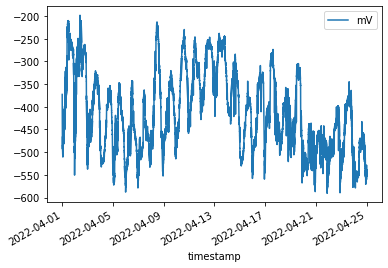

In [225]:
df.plot()

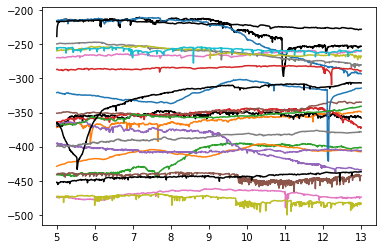

In [226]:
Y=[]
days = list(range(begin,end))
for jour in days:
    y = df.loc['2022-04-'+str(jour)+' 11:00:00':'2022-04-'+str(jour)+' 13:00:00']['mV']
    x = np.linspace(5,13,len(y))
    Y.append(y)
    if jour in black_days:
        plt.plot(x,y,color='black')
    else:
        plt.plot(x,y)

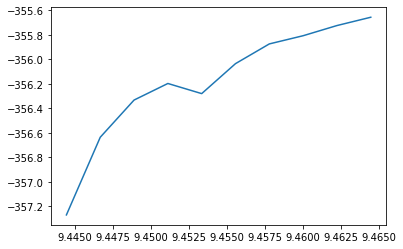

In [218]:
base = 2000
step = 10
plt.plot(x[base:base+step],Y[4][base:base+step])

Shape of embedded time series: (359, 20)


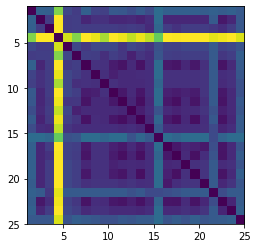

In [169]:
from gtda.time_series import SingleTakensEmbedding

embedding_dimension_periodic = 20
embedding_time_delay_periodic = 1
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)


#Embedding
Y_embedded = []
for y in Y:
    y_embedded = embedder_periodic.fit_transform(y)
    Y_embedded.append(y_embedded)
print(f"Shape of embedded time series: {y_embedded.shape}")

y_periodic_embedded = y_embedded[None, :, :]
y_nonperiodic_embedded = y_embedded[None, :, :]
from gtda.homology import VietorisRipsPersistence

# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1]

periodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
diagrams = []
for day,y_embedded in zip(days,Y_embedded):
    #print("Persistence diagram for periodic signal, day "+str(day))
    diagram = periodic_persistence.fit_transform(y_embedded[None,:,:])
    diagrams.append(diagram)
    
# Landscapes and images 
    
from gtda.diagrams import PersistenceImage,PersistenceLandscape
PL = PersistenceLandscape()
PI = PersistenceImage()
images,landscapes = [],[]
for d in diagrams:
    landscapes.append(PL.fit_transform(d)[0])
    images.append(PI.fit_transform(d)[0])
    
dist = np.zeros((len(landscapes),len(landscapes)))
for i in range(len(landscapes)):
    for j in range(len(landscapes)):
        dist[i,j] = np.max(np.abs(landscapes[i][1,:]-landscapes[j][1,:]))
extent = [begin,end,end,begin]
plt.imshow(dist,extent=extent)

In [170]:
(dist.sum(axis=1).argsort()[::-1]+1)

array([ 4, 15, 24,  1, 21,  5,  3,  6, 20, 23, 18,  8,  9,  2, 19, 14, 10,
        7, 16, 12, 17, 11, 13, 22])

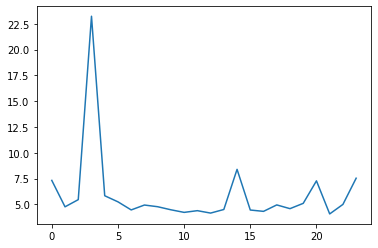

In [171]:
plt.plot(dist.sum(axis=1))

# Persistence landscapes

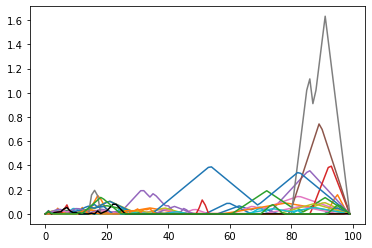

In [141]:
for day,land in zip(days,landscapes):
    if day in [23,25]:
        plt.plot(land[1,:],color='black')
    else:
        plt.plot(land[1,:])
plt.show()


In [ ]:
y_periodic_embedded = y_embedded[None, :, :]
y_nonperiodic_embedded = y_embedded[None, :, :]
from gtda.homology import VietorisRipsPersistence

# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1]

periodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
for day,y_embedded in zip(days,Y_embedded):
    print("Persistence diagram for periodic signal, day "+str(day))
    periodic_persistence.fit_transform_plot(y_embedded[None,:,:])


# UMAP

In [ ]:
#Visualizing
from gtda.plotting import plot_point_cloud
import matplotlib.pyplot as plt 

#UMAP here 
#plot_point_cloud(y_embedded)

import umap.umap_ as umap

reducer = umap.UMAP(n_components=2)
y_total_embedded  = np.concatenate(Y_embedded) 

y2d = reducer.fit_transform(y_total_embedded)


In [ ]:
base = 0
step = len(Y[0])
for jour in days:
    points = y2d[base:base+step]
    if jour in [23,25]:
        plt.scatter(points[:,0],points[:,1],color='grey',alpha=0.5)
    else:
        plt.scatter(points[:,0],points[:,1])
        
plot_point_cloud(y2d)

# Full pipeline for abnormal days 

/tmp/ipykernel_118554/4104748127.py:21: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



Shape of embedded time series: (23, 10)


/tmp/ipykernel_118554/4104748127.py:21: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



Shape of embedded time series: (23, 10)


/tmp/ipykernel_118554/4104748127.py:21: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



Shape of embedded time series: (23, 10)


/tmp/ipykernel_118554/4104748127.py:21: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



Shape of embedded time series: (23, 10)
Shape of embedded time series: (23, 10)
Shape of embedded time series: (23, 10)
Shape of embedded time series: (23, 10)
Shape of embedded time series: (23, 10)


[]

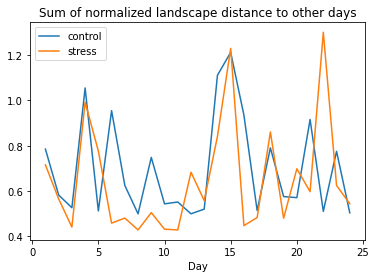

In [222]:
days = list(range(begin,end))


for plant_ids,label in zip([plant_ids1,plant_ids2],['control','stress']):
    total = np.zeros(len(days))
    for idx in range(len(plant_ids)):

        filters = [
            [
                ("plant_id", "=", plant_ids[idx]),
                ("year", "=", 2022),
                ("month","=",4),
                ("day","in",range(begin,end)),
            ]
        ]
        df = pd.read_parquet(DATA_DIR, filters=filters, columns=["mV", "timestamp"])
        df.set_index("timestamp", inplace=True)

        Y=[]
        for jour in days:
            y = df.loc['2022-04-'+str(jour)+' 11:00:00':'2022-04-'+str(jour)+' 13:00:00']['mV']
            x = np.linspace(5,13,len(y))
            Y.append(y)
        from gtda.time_series import SingleTakensEmbedding

        embedding_dimension_periodic = 10
        embedding_time_delay_periodic = 60
        stride = 300

        embedder_periodic = SingleTakensEmbedding(
            parameters_type="fixed",
            n_jobs=2,
            time_delay=embedding_time_delay_periodic,
            dimension=embedding_dimension_periodic,
            stride=stride,
        )


        #Embedding
        Y_embedded = []
        for y in Y:
            y_embedded = embedder_periodic.fit_transform(y)
            Y_embedded.append(y_embedded)
        print(f"Shape of embedded time series: {y_embedded.shape}")

        y_periodic_embedded = y_embedded[None, :, :]
        y_nonperiodic_embedded = y_embedded[None, :, :]
        from gtda.homology import VietorisRipsPersistence

        # 0 - connected components, 1 - loops, 2 - voids
        homology_dimensions = [0, 1]

        periodic_persistence = VietorisRipsPersistence(
            homology_dimensions=homology_dimensions, n_jobs=6
        )
        diagrams = []
        for day,y_embedded in zip(days,Y_embedded):
            #print("Persistence diagram for periodic signal, day "+str(day))
            diagram = periodic_persistence.fit_transform(y_embedded[None,:,:])
            diagrams.append(diagram)

        # Landscapes and images 

        from gtda.diagrams import PersistenceImage,PersistenceLandscape
        PL = PersistenceLandscape()
        PI = PersistenceImage()
        images,landscapes = [],[]
        for d in diagrams:
            landscapes.append(PL.fit_transform(d)[0])
            images.append(PI.fit_transform(d)[0])

        dist = np.zeros((len(landscapes),len(landscapes)))
        for i in range(len(landscapes)):
            for j in range(len(landscapes)):
                dist[i,j] = np.max(np.abs(landscapes[i][1,:]-landscapes[j][1,:]))
        extent = [begin,end,end,begin]
        distance_others = (dist.sum(axis=1))
        total+=distance_others/np.linalg.norm(distance_others)

    plt.plot(days,total,label=label)
plt.legend()
plt.title('Sum of normalized landscape distance to other days')
plt.xlabel('Day')
plt.plot()